# Processo seletivo -  iFood

Este relatório tem como objetivo contruir um modelo preditivo para aumentar os lucros da próxima campanha de marketing direto. A partir do modelo preditivo, espera-se direcionar a campanha para os clientes que tem maior probabilidade de comprar o produto promovido e aprimorar a eficiência da campanha. Além disso, com esse estudo, também espera-se entender melhor o perfil desses clientes para direcionamento de futuras campanhas.

Com esse objetivo em mente, o relatório é dividido em cinco partes:

1. Tratamento da base de dados

2. Análise exploratória dos dados

3. Segmentação de clientes

4. Modelo preditivo

5. Conclusões

# 1. Tratamento da base de dados

1. Valores nulos:
    a variável renda (Income) apresenta valores nulos que foram substituídos pela média da variável ao verificar que a distribuição da variável é centralizada.
    
    
2. Outliers:
     a variável renda (Income) apresenta um outlier extremo (666.666,0) que foi substituído pela soma da média da variável + 2 desvios padrões.
     
     
3. Padronização dos dados:
    * Year_Birth (ano de nascimento): valores relativos ao século XIX (1800 a 1899) foram considerados erros de digitação e os dois primeiros dígitos foram substituídos de '18' para '19'; além disso, havia um ano 1900 que foi substituído pela média da variável.
    * Marital_Status (estado civil): a variável categórica continha valores que não se encaixavam nas principais categorias, como 'Alone', 'YOLO' e 'Absurd'. Valores como esses foram substituídos pela categoria 'Others'. Ainda, as categorias 'Married' e 'Together' foram concatenadas na categoria 'Married'.
    
    
4. Criação de variáveis: algumas variáveis foram criadas para aprimorar a análise dos dados.
    * Age (idade): a variável foi criada a partir do ano de nascimento dos clientes.
    * TotalAccep: a variável representa a soma das campanhas em que o cliente comprou o produto ofertado.
    * NumKidsHome: a variável representa o número de filhos que moram com o cliente e é uma soma de duas variáveis: Kidhome (número de crianças em casa) e Teenhome (número de adolescentes em casa).
    * YearCustomer: representa o ano em que o cliente se registrou na empresa (criada a partir da data de registro.
    * TotalMnt: a variável representa a soma total dos gastos do cliente com a empresa.
    * AvgTicket: representa a média de valor gasto por compra e foi calculada a partir da média da variável TotalMnt.
    * Frequency: a variável pretende mostrar a frequência com que o cliente compra na loja e é calculada pela soma do número de pedidos do cliente no período acumulado da base de dados.
    
    
5. Cálculo do RFM: ainda nessa sessão, calcula-se um índice de engajamento dos clientes por meio das variáveis Recency,Frequency e TotalMnt. Quanto maior o valor gasto pelo cliente, a frequência de pedidos e mais recente for a última compra dele, maior é o índice que o cliente recebe. Ao final do cálculo, a coluna 'RFM' foi adicionada na base de dados. Esse índice será melhor explicado no próximo tópico. 

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import textwrap as tw
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

In [3]:
df = pd.read_csv('ml_project1_data.csv')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
df.info()

In [5]:
def tratamento_variaveis(df):
    df['Income'].fillna(round(df['Income'].mean(), 2), inplace=True)
    df['Year_Birth'] = df['Year_Birth'].astype(str).replace(r'^18', '19', regex=True).astype(int)
    df['Year_Birth'].replace(1900, int(df['Year_Birth'].mean()), inplace=True)
    df['Marital_Status'].replace(['Alone', 'YOLO', 'Absurd'], 'Others', inplace=True)
    df['Marital_Status'].replace(['Together'], 'Married', inplace=True)
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
    df['Income'].replace(666666.0, round(df['Income'].mean() + 2 * df['Income'].std(), 2), inplace=True)
    
def criacao_variaveis(df):
    df['Age'] = 2021 - df['Year_Birth'] # pode pegar ano automaticamente com datetime()
    df['TotalAccep'] = df.iloc[:, [20, 21, 22, 23, 24, 28]].sum(axis = 1, skipna = True)
    df['NumKidsHome'] = df['Kidhome'] + df['Teenhome']
    df['YearCustomer'] = df['Dt_Customer'].dt.strftime('%Y')

def calculo_rfm(new_df):
    new_df['ID'] = df['ID']
    new_df['Recency'] = df['Recency']
    new_df['Frequency'] = df.iloc[:, 15:19].sum(axis = 1, skipna = True)
    new_df['TotalMnt'] = df.iloc[:, 9:15].sum(axis = 1, skipna = True)
    new_df['AvgTicket'] = round(new_df['TotalMnt'] / new_df['Frequency'], 0)
    new_df['AvgTicket'].replace(np.inf, 0, inplace=True)
    new_df["RecencyScore"] = pd.cut(new_df["Recency"], 
                                bins=[-1, 
                                np.percentile(new_df["Recency"], 25), 
                                np.percentile(new_df["Recency"], 50), 
                                np.percentile(new_df["Recency"], 75), 
                                            new_df["Recency"].max()], 
                                labels=[4, 3, 2, 1]).astype("int")
    new_df["FrequencyScore"] = pd.cut(new_df["Frequency"], 
                                bins=[-1, 
                                np.percentile(new_df["Frequency"], 25), 
                                np.percentile(new_df["Frequency"], 50), 
                                np.percentile(new_df["Frequency"], 75), 
                                             new_df["Frequency"].max()], 
                                labels=[1, 2, 3, 4]).astype("int")
    new_df["MonetaryScore"] = pd.cut(new_df["TotalMnt"], 
                                bins=[-1, 
                                np.percentile(new_df["TotalMnt"], 25), 
                                np.percentile(new_df["TotalMnt"], 50), 
                                np.percentile(new_df["TotalMnt"], 75), 
                                             new_df["TotalMnt"].max()], 
                                labels=[1, 2, 3, 4]).astype("int")
    new_df['RFM'] = round((new_df["RecencyScore"] + new_df["FrequencyScore"] + new_df["MonetaryScore"]) / 3, 0)

In [6]:
tratamento_variaveis(df)
criacao_variaveis(df)
df_rfm = pd.DataFrame()
calculo_rfm(df_rfm)
df = df.merge(df_rfm[['ID', 'Frequency', 'TotalMnt', 'RFM', 'AvgTicket']], on='ID', how='left')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_Revenue,Response,Age,TotalAccep,NumKidsHome,YearCustomer,Frequency,TotalMnt,RFM,AvgTicket
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,11,1,64,1,0,2012,25,1617,3.0,65.0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,11,0,67,0,2,2014,6,27,2.0,4.0
2,4141,1965,Graduation,Married,71613.0,0,0,2013-08-21,26,426,...,11,0,56,0,0,2013,21,776,3.0,37.0
3,6182,1984,Graduation,Married,26646.0,1,0,2014-02-10,26,11,...,11,0,37,0,1,2014,8,53,2.0,7.0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,11,0,40,0,1,2014,19,422,2.0,22.0


# 2. Análise exploratória de dados

A análise exploratória dos dados é dividida em quatro partes, das quais pode-se observar os seguintes fatores:

1. Visão geral das vendas

Ao analisar os gastos dos clientes com diferentes segmentos de produtos, percebe-se que os segmentos que mais geram receita são vinhos e produtos raros à base de carne. Campanhas que focam nesses segmentos podem apresentar melhores resultados. 

Com relação aos canais de compra, é possível notar que a loja física é o canal com o maior número de produtos, seguido do website da empresa. A venda por catálogo é o canal de compra menos procurado dos três.

Os dados mostram que não há uma correlação significativa entre número de visitas mensais ao site e compras mais recentes. Além disso, há uma correlação negativa entre número de visitas mensais ao site e o valor total gasto em compras. Portanto, pode-se gerar três hipóteses a serem estudadas: 1) os clientes que visitam muito o website tendem a não gastar muito em compras, 2) as campanhas estão falhando em trazer lead qualificado ou 3) as campahas digitais estão visando tráfego e não conversão. Esse estudo pode ser realizado em análises posteriores como forma de tentar aumentar as vendas pelo website.



2. Dados demográficos dos clientes

Esse tópico tem o objetivo de observar o perfil demográfico dos clientes selecionados para receber a oferta da campanha piloto. Os dados demográficos mostram que 98% dos clientes tem mais de 30 anos e a média da idade dos clientes é de 52 anos. Isso mostra que os clientes não são tão jovens e 50% deles estão na faixa etária de 40 a 60 anos.

A variável renda está no intervalo entre 1730,00 e 163.000,00. Metade dos clientes recebe uma renda anual de até 52 mil e apenas 25% recebe mais de 68 mil.

Com relação ao nível de escolaridade, 89% dos clientes fizeram pelo menos graduação (parte deles são mestres e doutores). Já a variável estado civil mostra que 65% dos clientes são casados e 21% são solteiros (ou seja, solteiros e casados totalizam 86% dos clientes).



3. Histórico de campanhas

A fim de melhorar a performance da campanha publicitária, é preciso analisar o histórico das campanhas anteriores. É possível notar que a campanha piloto conseguiu engajar mais clientes que as últimas campanhas, ainda que apenas 15% dos clientes tenham aceitado a oferta. 

Além disso, percebe-se que as últimas três campanhas antes da piloto tiveram um nível de retorno constante (pouco mais de 160 clientes). Quando compara-se aos 334 clientes que aderiram à campanha piloto, nota-se que as últimas estratégias da equipe de marketing estão surtindo efeito. Porém, ainda há espaço para melhoras.

Existe uma correlação positiva entre o número total de ofertas aceitas pelo cliente e a renda do mesmo, assim como ao nível de engajamento do cliente (medida pelo índice RFM analisado no próximo tópico).

Além disso, há uma correlação positiva baixa entre o total de ofertas aceitas pelo cliente e o número de compras pelo site e pelo catálogo. Novamente, há indícios de que o funil de compra do website da empresa deve ser revisto.

Por fim, é interessante notar que clientes mais antigos aderiram mais à campanha piloto, ou seja, dos 15% de adesão da campanha piloto, 12% foram de clientes registrados em 2012 e 2013, contra 3% de clientes registrados em 2014.



4. Segmentação de clientes por RFM

A fim de entender o perfil do cliente, esse tópico analisa o índice de engajamento dos mesmos. O índice de engajamento foi calculado por meio do score RFM (Recency, Frequency, Monetary). Para realizar o cálculo, foi criada uma função que calcula o número de dias desde a última compra do cliente (recency), o número de pedidos que o cliente fez no período acumulado no banco de dados (frequency) e o total de gastos do cliente com a empresa (monetary). Cada um dos índices foi dividido por quartis e atribuído um número de 1 a 4 (1 representando os menores valores do índice e 4 representando os valores que representam maior engajamento). Por fim, foi calculada um média dos três valores (recency, frequency e monetary), gerando um score de engajamento para o cliente que vai de 1 (menos engajado) a 4 (mais engajado).

A análise dos clientes por índice de engajamento permite observar que os clientes com score 3 e 4 aderiram significativamente mais à campanha piloto (aproximadamente 20% e 30% dos clientes com scores 3 e 4, respectivamente, aderiram à campanha); enquanto, menos de 10% dos clientes com score 1 e 2 compraram o produto ofertado na campanha. Isso significa que uma segmentação que leve em consideração o índice de engajamento pode ser uma estratégia de direcionamento da campanha.

Com relação ao perfil dos clientes com índice de engajamento 3 e 4, ou seja, que tendem a aderir mais às campanhas, percebe-se que 92% dos clientes em ambos os score possuem nível de escolaridade de graduação, mestrado ou doutorado. Além disso, as variáveis RFM e renda apresentam 63% de correlação linear positiva, o que indica que clientes com maior índice de engajamento tendem a ter níveis maiores de renda anual. Por fim, o gráfico de dispersão entre total de gastos do cliente e renda, mostra que conforme o nível de renda aumenta o total de gastos do cliente na empresa também tende a aumentar (principalmente entre clientes com renda anual superior a 60 mil reais). Esse dado pode ser corroborado ao considerar que os segmentos de produtos mais comprados são vinho e produtos raros à base de carne. 

# 2.1 Visão geral de vendas

In [7]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

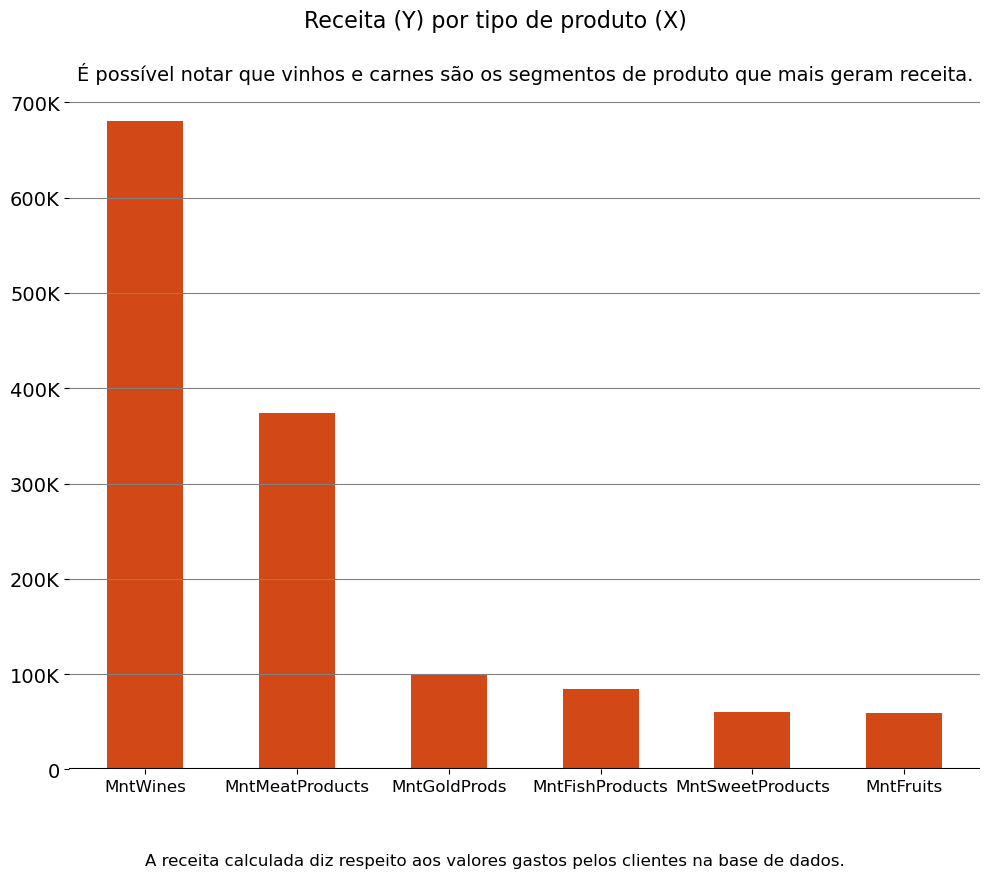

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
(df
  .iloc[:, 9:15].sum().sort_values(ascending=False)
  .plot.bar(legend=False, ax=ax, rot=0, zorder=0, color='#D34817')
 )
ax.set_title("É possível notar que vinhos e carnes são os segmentos de produto que mais geram receita.", fontsize=14)
ax.axhline(0, c="black")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(reformat_large_tick_values))
ax.yaxis.grid(True, color='gray', zorder=1)
ax.xaxis.grid(False)

fig.suptitle(f"Receita (Y) por tipo de produto (X)", y=1, fontsize=16)
footnote = f"A receita calculada diz respeito aos valores gastos pelos clientes na base de dados."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

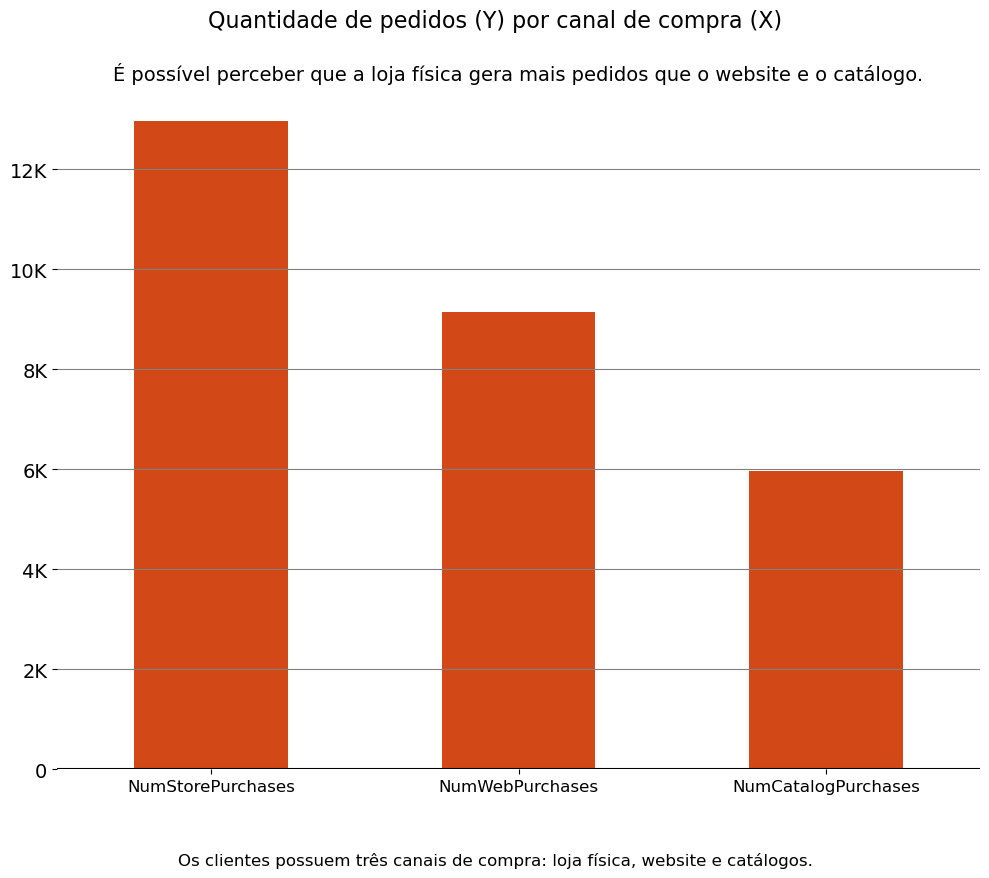

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
(df
  .loc[:, ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']]
  .sum()
  .sort_values(ascending=False)
  .plot.bar(legend=False, ax=ax, rot=0, zorder=0, color='#D34817', align='center')
 )
ax.set_title("É possível perceber que a loja física gera mais pedidos que o website e o catálogo.", 
             fontsize=14)
ax.axhline(0, c="black")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(reformat_large_tick_values))
ax.yaxis.grid(True, color='gray', zorder=1)
ax.xaxis.grid(False)

fig.suptitle(f"Quantidade de pedidos (Y) por canal de compra (X)", y=1, fontsize=16)
footnote = f"Os clientes possuem três canais de compra: loja física, website e catálogos."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

In [10]:
corr1 = df.loc[:, ['Recency', 'NumWebVisitsMonth']].corr()
corr2 = df.loc[:, ['TotalMnt', 'NumWebVisitsMonth']].corr()
print('Correlação entre visitas mensais ao site e recência de compras: ' + str(round(corr1['NumWebVisitsMonth']['Recency'], 2)))
print('Correlação entre visitas mensais ao site e total de gastos: ' + str(round(corr2['NumWebVisitsMonth']['TotalMnt'], 2)))

Correlação entre visitas mensais ao site e recência de compras: -0.02
Correlação entre visitas mensais ao site e total de gastos: -0.5


# 2.2 Dados demográficos dos clientes

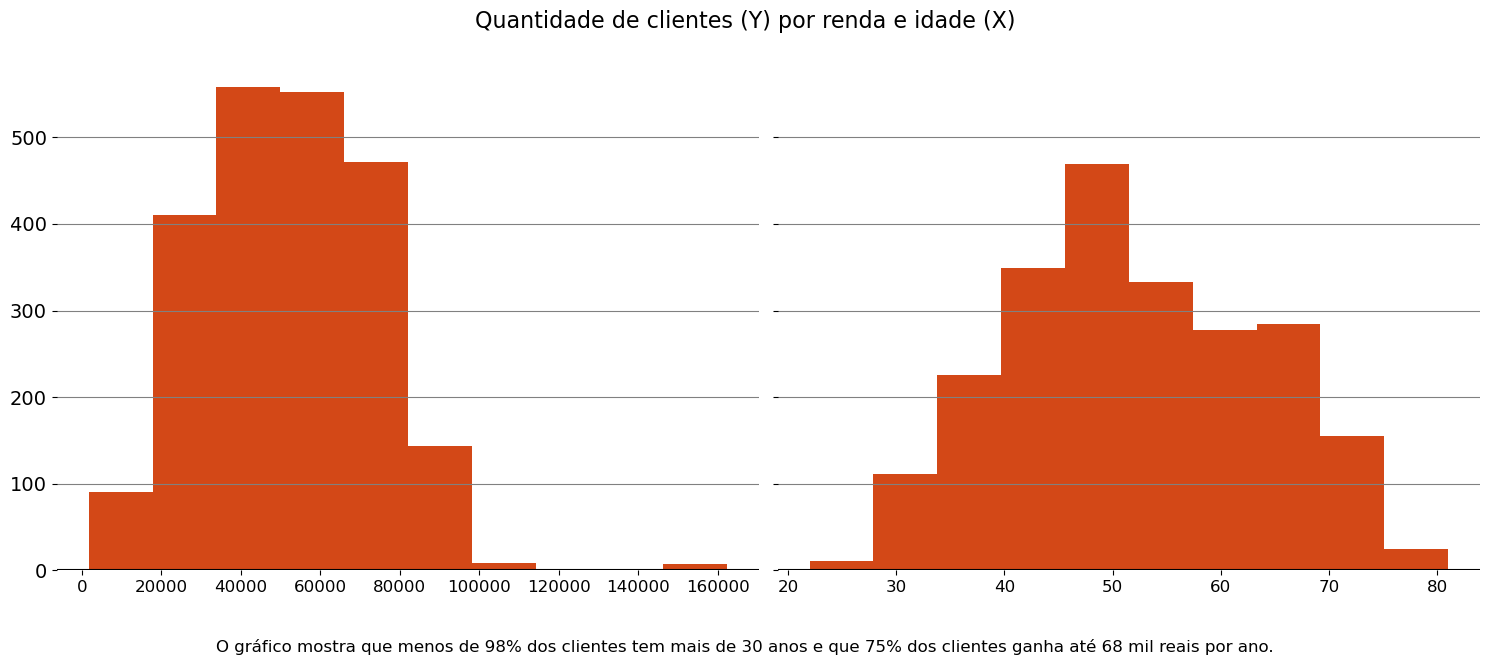

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), sharey=True)

ax1.hist(df['Income'], color='#D34817')
ax2.hist(df['Age'], color='#D34817')


for ax in ax1, ax2:
    ax.axhline(0, c="black")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(reformat_large_tick_values))
    ax.yaxis.grid(True, color='gray', zorder=1)
    ax.xaxis.grid(False)
    ax.set_facecolor('white')
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False

fig.suptitle(f"Quantidade de clientes (Y) por renda e idade (X)", y=1, fontsize=16)
footnote = f"O gráfico mostra que menos de 98% dos clientes tem mais de 30 anos e que 75% dos clientes ganha até 68 mil reais por ano."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)
plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
    
plt.show()

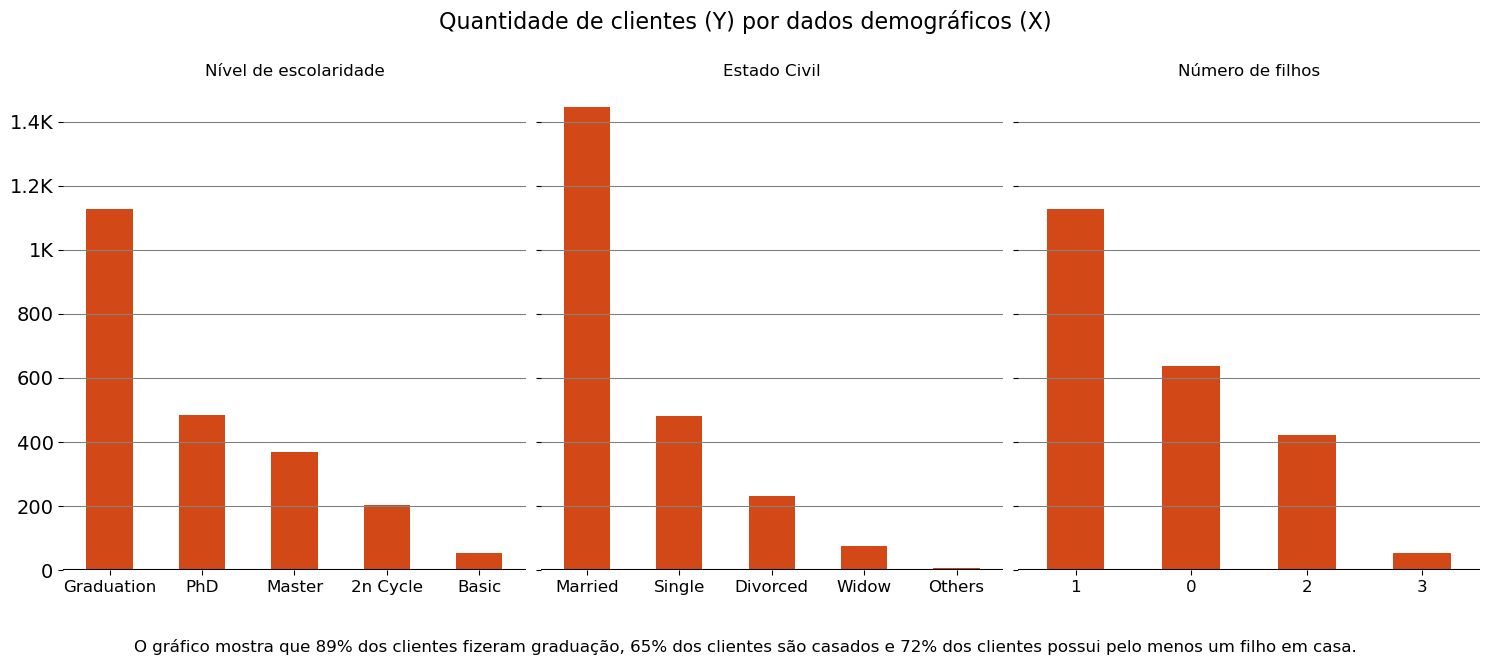

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6), sharey=True)

graph_1 = (df.loc[:, ['Education', 'ID']].groupby(['Education']).agg(NumeroClientes=('ID', 'count'))
           .sort_values('NumeroClientes', ascending=False)
           .plot.bar(ax=ax1, legend=False, rot=0, zorder=0, color='#D34817', align='center', xlabel='', 
                     title='Nível de escolaridade'))
graph_2 = (df.loc[:, ['Marital_Status', 'ID']].groupby(['Marital_Status']).agg(NumeroClientes=('ID', 'count'))
           .sort_values('NumeroClientes', ascending=False)
           .plot.bar(ax=ax2, legend=False, rot=0, zorder=0, color='#D34817', align='center', xlabel='',
                    title='Estado Civil'))
graph_3 = (df.loc[:, ['NumKidsHome', 'ID']].groupby(['NumKidsHome']).agg(NumeroClientes=('ID', 'count'))
           .sort_values('NumeroClientes', ascending=False)
           .plot.bar(ax=ax3, legend=False, rot=0, zorder=0, color='#D34817', align='center', xlabel='',
                    title='Número de filhos'))

for ax in ax1, ax2, ax3:
    ax.axhline(0, c="black")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(reformat_large_tick_values))
    ax.yaxis.grid(True, color='gray', zorder=1)
    ax.xaxis.grid(False)
    ax.set_facecolor('white')
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False

fig.suptitle(f"Quantidade de clientes (Y) por dados demográficos (X)", y=1, fontsize=16)
footnote = f"O gráfico mostra que 89% dos clientes fizeram graduação, 65% dos clientes são casados e 72% dos clientes possui pelo menos um filho em casa."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

# 2.3 Histórico de campanhas

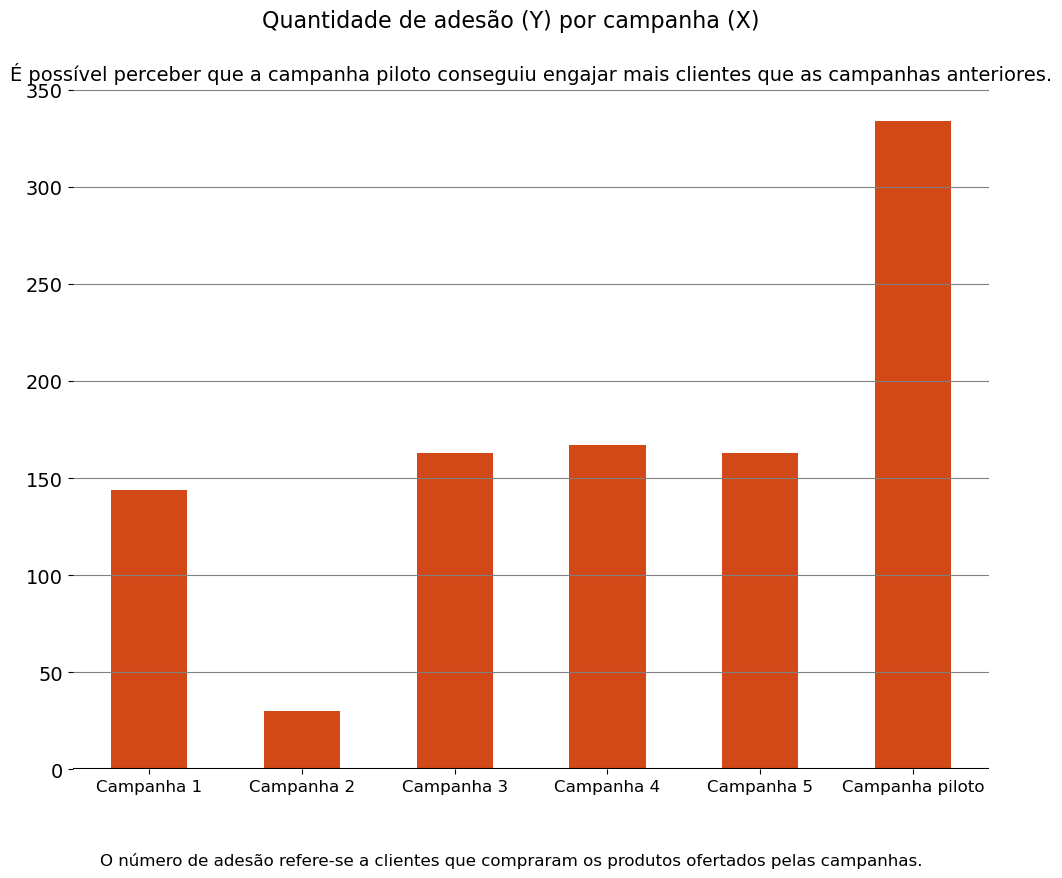

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
(df
 .loc[:, ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]
 .rename(columns={'AcceptedCmp1': 'Campanha 1', 'AcceptedCmp2': 'Campanha 2', 'AcceptedCmp3': 'Campanha 3',
                 'AcceptedCmp4': 'Campanha 4', 'AcceptedCmp5': 'Campanha 5', 'Response': 'Campanha piloto'})
 .sum()
 .plot.bar(legend=False, ax=ax, rot=0, zorder=0, color='#D34817', align='center'))

ax.set_title("É possível perceber que a campanha piloto conseguiu engajar mais clientes que as campanhas anteriores.", 
             fontsize=14)

ax.axhline(0, c="black")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(reformat_large_tick_values))
ax.yaxis.grid(True, color='gray', zorder=1)
ax.xaxis.grid(False)

fig.suptitle(f"Quantidade de adesão (Y) por campanha (X)", y=1, fontsize=16)
footnote = f"O número de adesão refere-se a clientes que compraram os produtos ofertados pelas campanhas."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

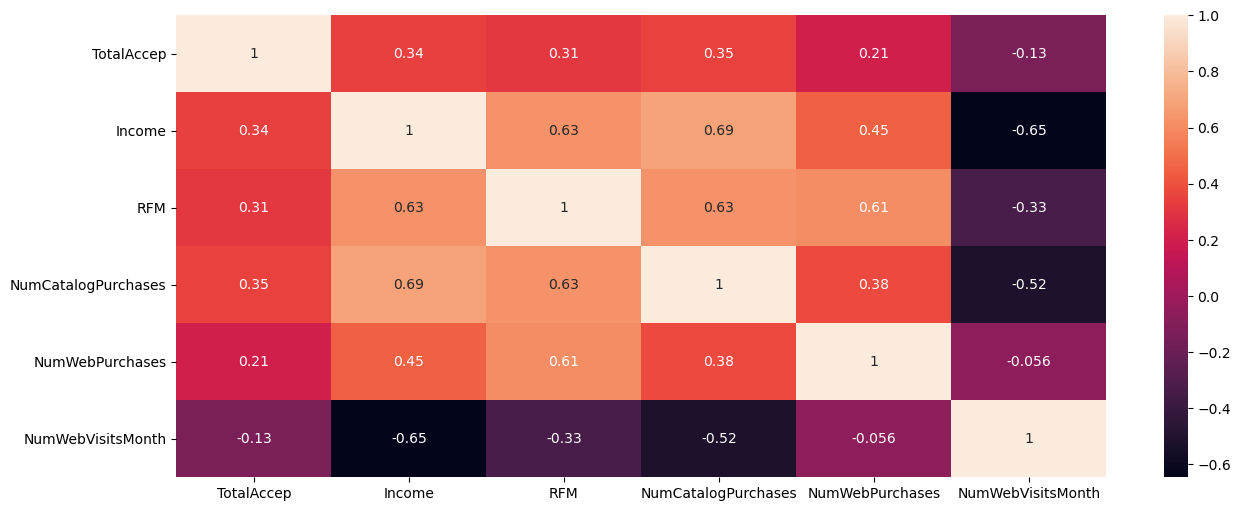

In [15]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.loc[:, ['TotalAccep', 'Income', 'RFM', 'NumCatalogPurchases', 'NumWebPurchases', 'NumWebVisitsMonth']].corr(), annot=True, cmap='rocket')
plt.show()

In [16]:
histCustomer = df.loc[:, ['YearCustomer', 'Response', 'ID']].groupby(['YearCustomer', 'Response']).agg(TotalAdesao=('ID', 'count')).reset_index()

histCustomer['%'] = 100 * (histCustomer['TotalAdesao'] / sum(histCustomer['TotalAdesao']))
histCustomer

,YearCustomer,Response,TotalAdesao,%
0,2012,0,362,16.160714
1,2012,1,132,5.892857
2,2013,0,1035,46.205357
3,2013,1,154,6.875000
4,2014,0,509,22.723214
5,2014,1,48,2.142857


# 4) Segmentação de clientes por RFM

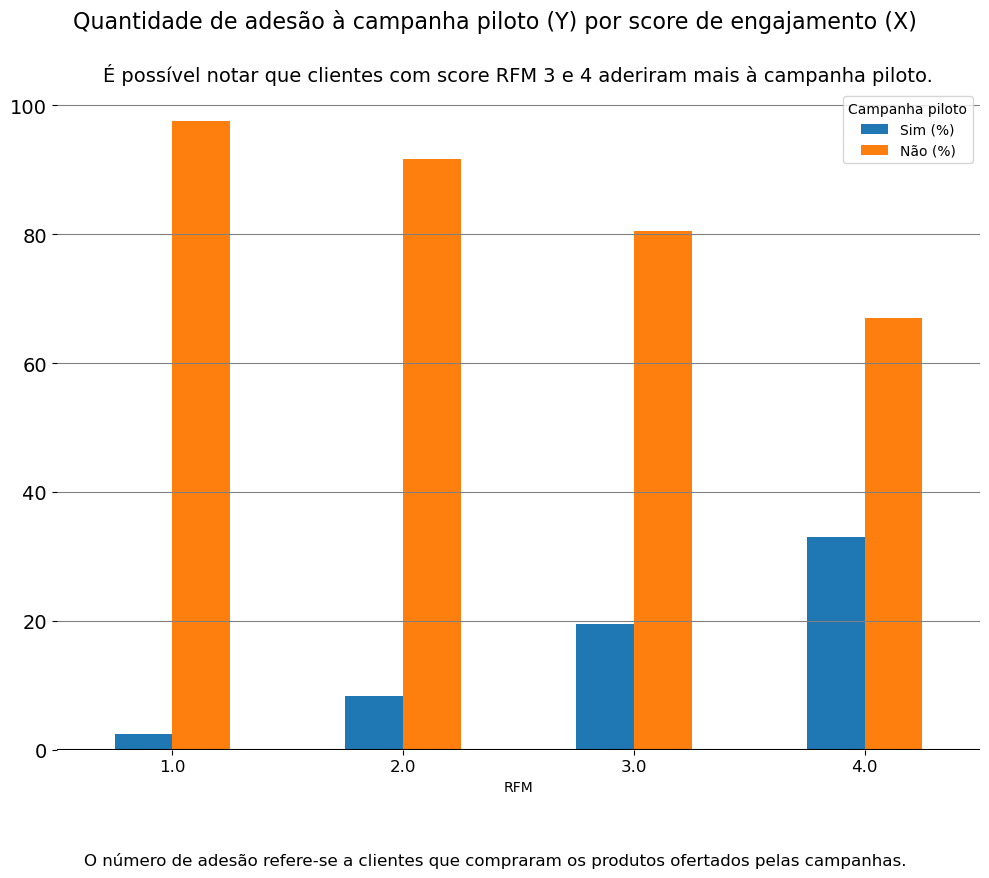

In [58]:
df_pivot = df.loc[:,['RFM', 'Response', 'ID']].rename(columns={'Response': 'Campanha piloto'}).groupby(['Campanha piloto', 'RFM']).agg(TotalClientes=('ID', 'count')).reset_index().pivot(index='RFM', columns='Campanha piloto', values='TotalClientes')
df_pivot['Sim (%)'] = round(100 * (df_pivot[1] / (df_pivot[0] + df_pivot[1])), 2)
df_pivot['Não (%)'] = round(100 * (df_pivot[0] / (df_pivot[0] + df_pivot[1])), 2)
df_pivot = df_pivot.drop(columns=[0, 1])

fig, ax = plt.subplots(1, 1, figsize=(10,8))
(df_pivot
 .plot.bar(legend=True, ax=ax, rot=0, zorder=0, align='center'))

ax.set_title("É possível notar que clientes com score RFM 3 e 4 aderiram mais à campanha piloto.", 
             fontsize=14)

ax.axhline(0, c="black")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.grid(True, color='gray', zorder=1)
ax.xaxis.grid(False)
ax.xlabel=''

fig.suptitle(f"Quantidade de adesão à campanha piloto (Y) por score de engajamento (X)", y=1, fontsize=16)
footnote = f"O número de adesão refere-se a clientes que compraram os produtos ofertados pelas campanhas."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

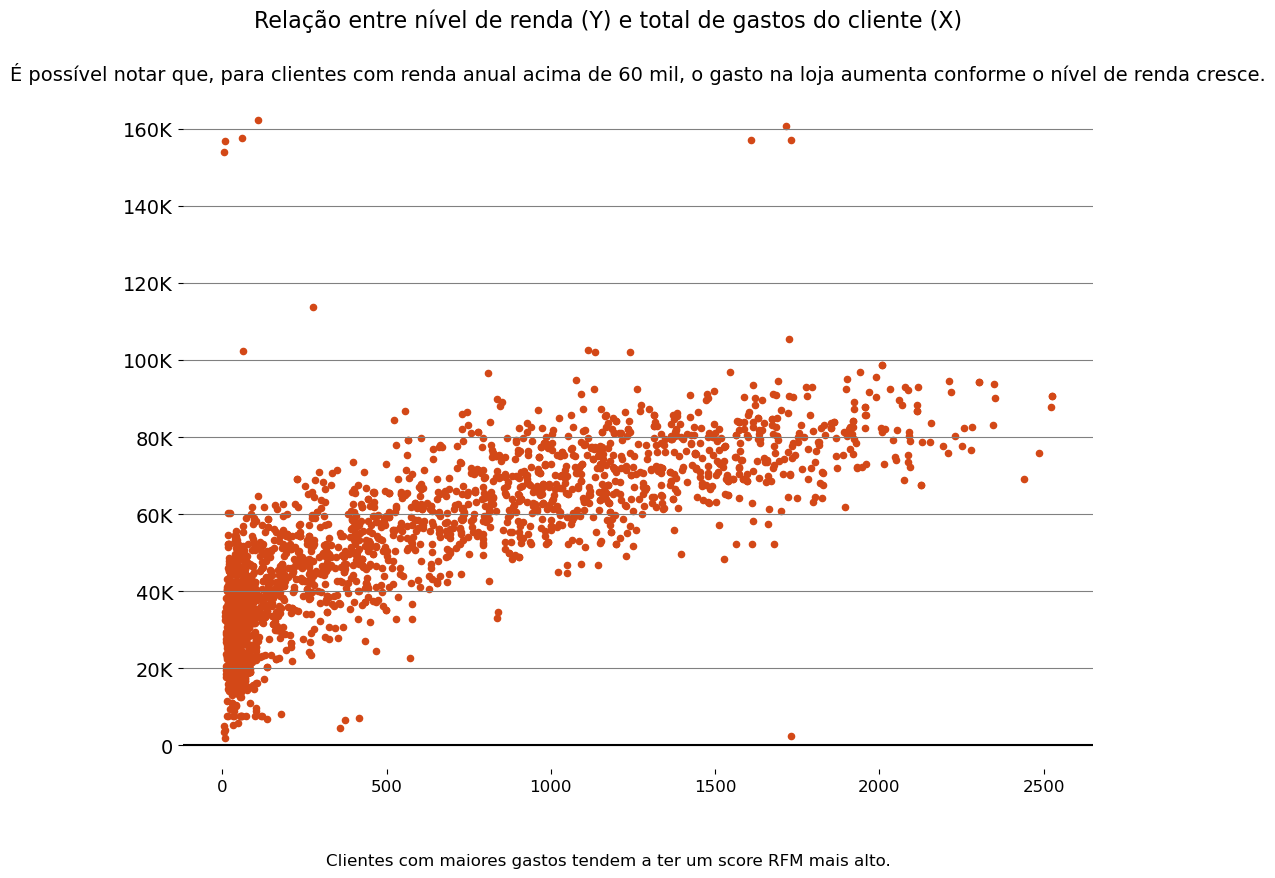

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
(df
 .plot.scatter(x='TotalMnt', y='Income', legend=False, ax=ax, zorder=0, color='#D34817'))

ax.set_title("É possível notar que, para clientes com renda anual acima de 60 mil, o gasto na loja aumenta conforme o nível de renda cresce.", 
             fontsize=14)

ax.axhline(0, c="black")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(reformat_large_tick_values))
ax.yaxis.grid(True, color='gray', zorder=1)
ax.xaxis.grid(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig.suptitle(f"Relação entre nível de renda (Y) e total de gastos do cliente (X)", y=1, fontsize=16)
footnote = f"Clientes com maiores gastos tendem a ter um score RFM mais alto."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

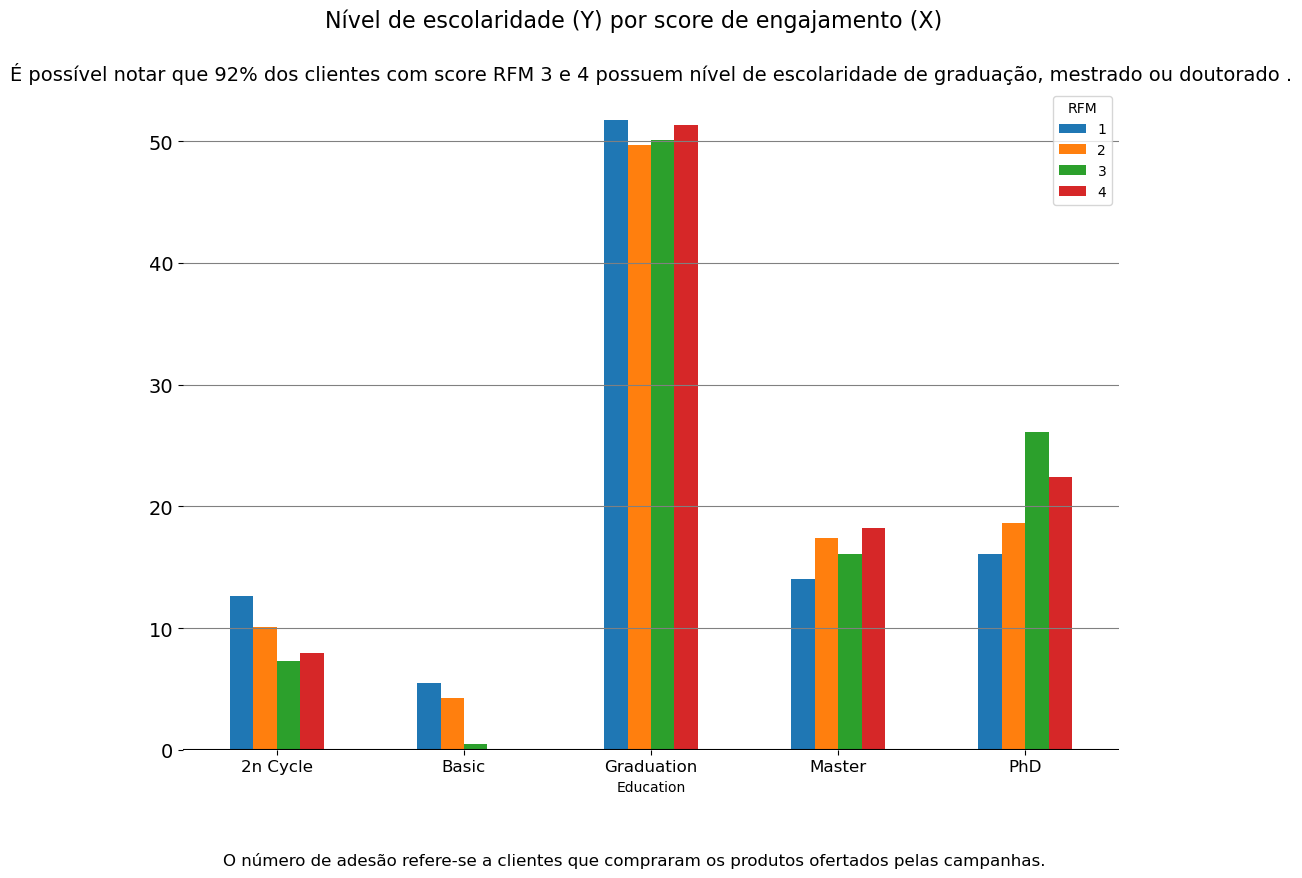

In [59]:
df_pivot = df.loc[:,['RFM', 'Education', 'ID']].groupby(['Education', 'RFM']).agg(TotalClientes=('ID', 'count')).reset_index().pivot(index='Education', columns='RFM', values='TotalClientes')
df_pivot.fillna(0, inplace=True)
df_pivot['1'] = round(100 * (df_pivot[1] / (sum(df_pivot[1]))), 2)
df_pivot['2'] = round(100 * (df_pivot[2] / (sum(df_pivot[2]))), 2)
df_pivot['3'] = round(100 * (df_pivot[3] / (sum(df_pivot[3]))), 2)
df_pivot['4'] = round(100 * (df_pivot[4] / (sum(df_pivot[4]))), 2)
df_pivot = df_pivot.drop(columns=[1, 2, 3, 4])

fig, ax = plt.subplots(1, 1, figsize=(10,8))
(df_pivot
 .plot.bar(legend=True, ax=ax, rot=0, zorder=0, align='center'))

ax.set_title("É possível notar que 92% dos clientes com score RFM 3 e 4 possuem nível de escolaridade de graduação, mestrado ou doutorado .", 
             fontsize=14)

ax.axhline(0, c="black")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.grid(True, color='gray', zorder=1)
ax.xaxis.grid(False)
ax.xlabel=''

fig.suptitle(f"Nível de escolaridade (Y) por score de engajamento (X)", y=1, fontsize=16)

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

# 3. Segmentação de clientes

A clusterização foi feita a partir das conclusões da análise exploratória de dados, focada em variáveis que podem impactar probabilidade do cliente aceitar a oferta da campanha: renda anual, nível de escolaridade do cliente e índice de engajamento medido pelo score RFM.

As variáveis selecionadas foram usadas para criar uma segmentação de clientes a partir de um algoritmo de clusterização. A análise usou o algoritmo K-Means e se baseou em variáveis categóricas. Para tanto, a variável renda foi transformada em três níveis de acordo com a distribuição da variável: baixa (até 40.000,00), média (entre 40.000,00 e 60.000,00) e alta (acima de 60.000,00). Além disso, todas as variáveis foram tratadas pelo algoritmo Ordinal Encoder, como forma de transformar as variáveis em númericas e ordinais.

A segmentação criada permite estabelecer perfis de consumidores e direcionar de forma mais efetiva as campanhas.

1.  Gold (cluster 0): 94% desse cluster possui índice de engajamento 3 e 4, renda média de aproximadamente 60 mil e todos possuem nível de escolaridade de mestrado ou doutorado. O cluster tem um bom histórico de aceite de ofertas de campanha e pode ser um dos segmentos de clientes para direcionamento da sexta campanha. Além disso, esses clientes tem a maior média de gasto com vinhos e tem a segunda maior média de gasto com produtos gold (51,50). Por isso, são denomidados clientes gold.
    * Renda: a média de renda do cluster é de 67.523,48 com um intervalo de 40.101,00 a 162.397,00.
    * Engajamento (RFM): 72% dos clientes do cluster possuem índice de engajamento 3 e 22% possuem score 4.
    * Nível de escolaridade: 100% do cluster tem nível de escolaridade de mestrado ou doutorado.
    * Histórico de aceite de ofertas: os clientes do cluster 0 e do cluster 2 são os que mais aceitaram ofertas passadas e a oferta da campanha piloto.


2. Promissores (cluster 1): 93% dos clientes possuem índice de engajamento de 1 e 2 (baixo engajamento), com renda média anual de 35 mil reais e nível de escolaridade de graduação e mestrado. Esses clientes aumentaram o nível de engajamento com campanhas na campanha piloto, ou seja, o produto anunciado pode interessar a esse grupo. É um grupo que pode ser um dos focos da sexta campanha. 
    * Renda: a média de renda do cluster é de 35.171,57 e 75% dos clientes recebem até 43.057,00.
    * Engajamento (RFM): 23% dos clientes tem índice de engajamento 1 e 70% possuem score 2. 	
    * Nível de escolaridade: 100% do cluster tem nível de escolaridade de graduação e mestrado.
    * Histórico de aceite de ofertas: esse foi o terceiro cluster que mais comproou o produto da campanha piloto e teve um aumento significativo de pessoas que aceitaram a oferta piloto quando comparados a ofertas passadas.


3. Silver (cluster 2): 83% dos clientes do cluster possuem índice de engajamento entre 3 e 4, a renda média anual é de aproximadamente 68 mil reais e 100% do cluster possui nível de escolaridade de ensino médio ou graduação. O cluster tem um bom histórico de aceite de ofertas e pode ser um dos segmentos de clientes para direcionamento da sexta campanha. Além disso, esses clientes tem a maior média de gastos em produtos gold (78,59) e em produtos raros à base de carne (314,93). A partir dessas informações, são denomidados clientes silver.
    * Renda: a média de renda do cluster é de 68.728,71 com um intervalo de 2.447,00 a 157.146,00.
    * Engajamento (RFM): 69% dos clientes tem índice de engajamento 3 e 24% possuem score 4.
    * Nível de escolaridade: 90% do cluster tem nível de escolaridade de graduação e os outros 10% ensino médio.
    * Histórico de aceite de ofertas: os clientes do cluster 0 e do cluster 2 são os que mais aceitaram ofertas passadas e a oferta piloto.


4. Leais (cluster 3): 66% dos clientes possuem índice de engajamento entre 1 e 2, a média da renda anual é de aproximadamente 31 mil reais e 100% dos clientes possuem nível de escolaridade de fundamental e ensino médio. Está entre um dos dois clusters que menos aceitam ofertas e provavelmente não deve ser um dos focos da sexta campanha. Como esses clientes possuem bons índices de frequência de compras e de recência, mas não costumam gastar valores altos, são chamados de clientes leais.
    * Renda: a média de renda do cluster é de 31.634,64 e mediana de 26.907,00.
    * Engajamento (RFM): 27% dos clientes tem índice de engajamento 1 e 59% possuem score 2.
    * Nível de escolaridade: 100% dos clientes do cluster tem nível de escolaridade de fundamental e ensino médio.
    * Histórico de aceite de ofertas: os clientes do cluster 3 e do cluster 4 são os que menos aceitaram ofertas passadas e a oferta piloto.


5. Desmotivados (cluster 4): 92% dos clientes possuem um índice de engajamento de 1 ou 2, a renda média anual do grupo é de 38 mil e o nível de escolaridade é de mestrado ou doutorado. Está entre um dos dois clusters que menos aceitam ofertas e provavelmente não deve ser um dos focos da sexta campanha. Como possuem índice de engajamento baixo e não costumam gastar valores altos, são chamados de clientes desmotivados.
    * Renda: a média de renda do cluster é de 38.691,54 e 75% dos clientes recebem até 46.060,50.
    * Engajamento (RFM): 36% dos clientes tem índice de engajamento 1 e 56% possuem score 2.
    * Nível de escolaridade: 100% do cluster tem nível de escolaridade de mestrado ou doutorado.
    * Histórico de aceite de ofertas: os clientes do cluster 3 e do cluster 4 são os que menos aceitaram ofertas passadas e a oferta piloto.

A partir dos clusters, é possível perceber que os clientes podem ser segmentados de acordo com variáveis relacionadas ao poder aquisitivo (renda, nível de escolaridade) e ao nível de engajamento com a empresa. Portanto, conclui-se que clientes com maiores níveis de renda e engajamento possuem um melhor histórico de engajamento com campanhas de marketing, enquanto clientes com níveis mais baixos de renda e de score RFM tendem a aceitar menos as ofertas das campanhas. O nível de escolaridade não deve ser usado como variável única para definir se o cliente provavelmente aceitará ou não a oferta, mas pode ser usada como método de seleção de clientes quando combinada com variáveis de renda e engajamento.

Assim, as próximas campanhas podem criar mensagens para os públicos selecionados, aumentando o engajamento dos públicos que já participam das ofertas (clusters 0 e 2) e gerando participação de grupos que geralmente não são engajados pelas campanhas (grupos os clusters 1, 3 e 4).

# 3.1 Preparação da base de dados

In [20]:
cluster_df = df.loc[:, ['Income', 'Education', 'RFM']]
cluster_df['Income'] = cluster_df['Income'].apply(lambda x: 0 if (x <= 40000) else x) # baixa
cluster_df['Income'] = cluster_df['Income'].apply(lambda x: 1 if (x > 40000 and x <= 60000) else x) # média
cluster_df['Income'] = cluster_df['Income'].apply(lambda x: 2 if (x > 60000) else x) # alta
cluster_df.head()

,Income,Education,RFM
0,1.0,Graduation,3.0
1,1.0,Graduation,2.0
2,2.0,Graduation,3.0
3,0.0,Graduation,2.0
4,1.0,PhD,2.0


In [21]:
oe = OrdinalEncoder()
column_transform = make_column_transformer((oe, ['Income', 'Education', 'RFM']))
cluster_df = column_transform.fit_transform(cluster_df)

# 3.2 Clustering

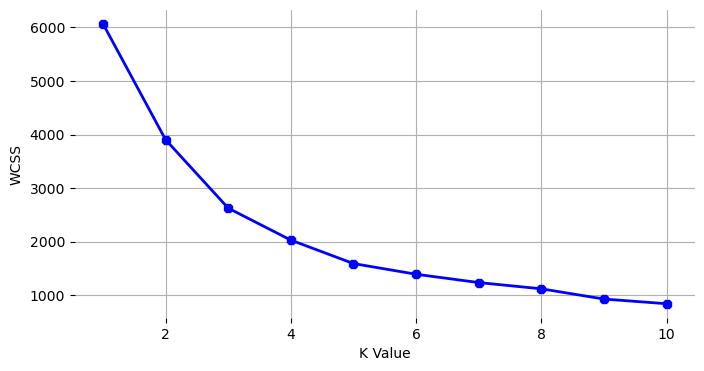

In [22]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(cluster_df)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(range(1,11), wcss, linewidth=2, color='blue', marker='8')
plt.xlabel('K Value')
plt.ylabel('WCSS')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=5, init=centroids)
cluster = kmeans.fit_predict(cluster_df)
df['Cluster'] = cluster

C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [26]:
centroids = kmeans.cluster_centers_
centroids = np.array([[1.6918239 , 3.59538784, 2.16561845],
       [0.3358209 , 2.20298507, 0.84776119],
       [1.76103501, 1.80517504, 2.1674277 ],
       [0.31088083, 0.27979275, 0.86010363],
       [0.40740741, 3.83127572, 0.71193416]])
centroids

array([[1.6918239 , 3.59538784, 2.16561845],
       [0.3358209 , 2.20298507, 0.84776119],
       [1.76103501, 1.80517504, 2.1674277 ],
       [0.31088083, 0.27979275, 0.86010363],
       [0.40740741, 3.83127572, 0.71193416]])

# 3.3 Resultados da segmentação

In [27]:
df.loc[:,['Income', 'Cluster']].groupby('Cluster').describe()

Income                                                         \
         count          mean           std      min      25%      50%   
Cluster                                                                 
0        477.0  67523.475891  15610.584072  40101.0  56937.0  66426.0   
1        669.0  35171.573617  12441.999720   1730.0  27038.0  35178.0   
2        658.0  68728.707599  12978.930358   2447.0  60544.0  69139.0   
3        193.0  31634.636010  14957.901682   7500.0  20491.0  26907.0   
4        243.0  38691.542181  13452.858471   4023.0  31615.5  37395.0   

                             
              75%       max  
Cluster                      
0        77598.00  162397.0  
1        43057.00  153924.0  
2        77374.75  157146.0  
3        42395.00   80910.0  
4        46060.50  156924.0

In [28]:
df.loc[:,['MntGoldProds', 'Cluster']].groupby(['Cluster']).describe()

MntGoldProds                                                      
               count       mean        std  min   25%   50%     75%    max
Cluster                                                                   
0              477.0  51.526205  49.096435  0.0  15.0  36.0   70.00  242.0
1              669.0  21.699552  32.983815  0.0   5.0  12.0   25.00  321.0
2              658.0  78.586626  60.411823  0.0  32.0  58.0  110.75  362.0
3              193.0  26.839378  34.887619  0.0   9.0  17.0   30.00  232.0
4              243.0  10.798354  21.909951  0.0   2.0   6.0   12.00  291.0

In [29]:
df.loc[:,['TotalMnt', 'Cluster']].groupby(['Cluster']).describe()

TotalMnt                                                         \
           count         mean         std   min    25%     50%      75%   
Cluster                                                                   
0          477.0  1058.257862  538.538439  59.0  608.0  1021.0  1477.00   
1          669.0   136.312407  153.091983   5.0   41.0    71.0   178.00   
2          658.0  1069.908815  490.090823  18.0  694.0  1050.5  1407.75   
3          193.0   165.430052  249.215993  13.0   43.0    66.0   172.00   
4          243.0   103.201646  111.449820   8.0   38.0    62.0   132.00   

                 
            max  
Cluster          
0        2525.0  
1        1027.0  
2        2524.0  
3        1679.0  
4         682.0

In [30]:
table = df.loc[:,['RFM', 'Cluster', 'ID']].groupby(['Cluster', 'RFM']).agg(TotalClientes=('ID', 'count')).reset_index()
df_pivot = table.pivot(index='Cluster', columns='RFM', values='TotalClientes')
df_pivot.fillna(0, inplace=True)
df_pivot['sum'] = df_pivot[1] + df_pivot[2] + df_pivot[3] + df_pivot[4]
df_pivot['1 (%)'] = round(100 * (df_pivot[1] / df_pivot['sum']), 2)
df_pivot['2 (%)'] = round(100 * (df_pivot[2] / df_pivot['sum']), 2)
df_pivot['3 (%)'] = round(100 * (df_pivot[3] / df_pivot['sum']), 2)
df_pivot['4 (%)'] = round(100 * (df_pivot[4] / df_pivot['sum']), 2)
df_pivot = df_pivot.drop(columns=['sum'])
df_pivot

RFM,1.0,2.0,3.0,4.0,1 (%),2 (%),3 (%),4 (%)
Cluster,,,,,,,,
0,0.0,28.0,342.0,107.0,0.00,5.87,71.70,22.43
1,151.0,469.0,49.0,0.0,22.57,70.10,7.32,0.00
2,0.0,47.0,455.0,156.0,0.00,7.14,69.15,23.71
3,53.0,114.0,26.0,0.0,27.46,59.07,13.47,0.00
4,88.0,137.0,18.0,0.0,36.21,56.38,7.41,0.00


In [31]:
table = df.loc[:,['Education', 'Cluster', 'ID']].groupby(['Cluster', 'Education']).agg(TotalClientes=('ID', 'count')).reset_index()
df_pivot = table.pivot(index='Education', columns='Cluster', values='TotalClientes')
df_pivot.fillna(0, inplace=True)
df_pivot['sum'] = df_pivot[1] + df_pivot[2] + df_pivot[3] + df_pivot[4]
df_pivot['1 (%)'] = round(100 * (df_pivot[1] / df_pivot['sum']), 2)
df_pivot['2 (%)'] = round(100 * (df_pivot[2] / df_pivot['sum']), 2)
df_pivot['3 (%)'] = round(100 * (df_pivot[3] / df_pivot['sum']), 2)
df_pivot['4 (%)'] = round(100 * (df_pivot[4] / df_pivot['sum']), 2)
df_pivot = df_pivot.drop(columns=['sum'])
df_pivot

Cluster,0,1,2,3,4,1 (%),2 (%),3 (%),4 (%)
Education,,,,,,,,,
2n Cycle,0.0,0.0,64.0,139.0,0.0,0.00,31.53,68.47,0.00
Basic,0.0,0.0,0.0,54.0,0.0,0.00,0.00,100.00,0.00
Graduation,0.0,533.0,594.0,0.0,0.0,47.29,52.71,0.00,0.00
Master,193.0,136.0,0.0,0.0,41.0,76.84,0.00,0.00,23.16
PhD,284.0,0.0,0.0,0.0,202.0,0.00,0.00,0.00,100.00


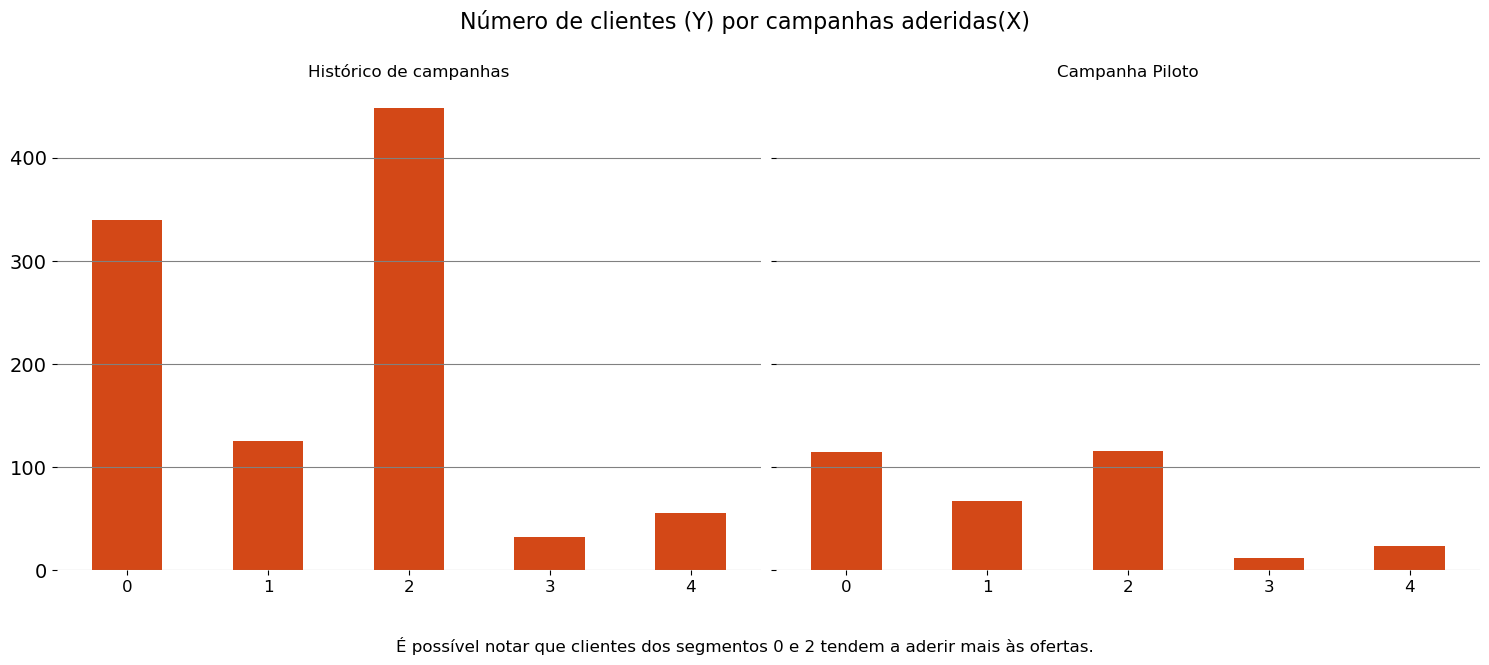

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), sharey=True)

graph_1 = (df.loc[:, ['TotalAccep', 'Cluster']].groupby('Cluster').agg(Campanhas_aderidas=('TotalAccep', 'sum'))
           .plot.bar(ax=ax1, legend=False, rot=0, zorder=0, color='#D34817', align='center', xlabel='', 
                     title='Histórico de campanhas'))
graph_2 = (df.loc[:, ['Response', 'Cluster']].groupby('Cluster').agg(CampPiloto=('Response', 'sum'))
           .plot.bar(ax=ax2, legend=False, rot=0, zorder=0, color='#D34817', align='center', xlabel='',
                    title='Campanha Piloto'))

for ax in ax1, ax2:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(reformat_large_tick_values))
    ax.yaxis.grid(True, color='gray', zorder=1)
    ax.xaxis.grid(False)
    ax.set_facecolor('white')

fig.suptitle(f"Número de clientes (Y) por campanhas aderidas(X)", y=1, fontsize=16)
footnote = f"É possível notar que clientes dos segmentos 0 e 2 tendem a aderir mais às ofertas."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)

plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
plt.show()

# 4. Modelo preditivo

Esse tópico se destina à construção do modelo preditivo. Espera-se prever os clientes que tem maior probabilidade de aceitar a oferta da sexta campanha de marketing por meio de um algoritmo de classificação. A variável resposta é a "Response", coluna que indica se os clientes aceitaram ou não a campanha piloto. 

Antes de rodar os modelos, algumas variáveis foram excluídas da base de treino, pois não se mostravam necessárias para o algoritmo de classificação: 'ID', 'Dt_Customer' (uma variável de YearCustomer foi criada e substituiu a necessidade dessa variável), 'Year_Birth' (uma variável Age foi criada e substituiu a necessidade dessa variável), 'Z_CostContact' e 'Z_Revenue' (apresentam valores iguais para todos os clientes da base de dados, portanto não seriam variáveis de diferenciação entre os clientes).

Foram realizados os seguintes tratamentos na base de dados:
* Dados desbalanceados: a base de dados apresenta um desbalanceamento com relação à resposta positiva à campanha piloto (15% da base) e à resposta negativa (85% da base). Modelos criados com dados desbalanceados tendem a apresentar overfitting. Portanto, duas técnicas diferentes foram usadas para resolver o problema:
    * Random Oversampling: essa técnica cria novas observações da classe minoritária com o objetivo de igualar a proporção das categorias. Essa técnica tende ao overfitting, pois aumenta a proporção dos dados na base. Portanto, ao rodar os modelos comparou-se a acurácia, o F1-Score e a AUROC, como forma de verificar se há overfitting.
    * Cost-Sensitive Logistic Regression: nessa técnica, os dados desbalanceados são ajustados pelo próprio modelo de regressão logística. Inverte-se o peso das categorias majoritárias e minoritárias para compensar a diferença no número de observações de cada uma delas.
* Scaling: para padronizar a escala das variáveis numéricas da base de dados, aplicou-se o Robust Scaler nas variáveis numéricas de todos os modelos. Essa técnica específica foi selecionada por reagir bem a outliers, presentes na base de dados. O Robust Scaler usa a distância interquartil dos dados para criar a escala padronizada, por isso, os outliers são acomodados sem enviesar a escala da variável.
* Categorical encoders: a fim de adicionar as variáveis categóricas no modelo, utilizou-se a técnica de categorical encoders denominada M-Estimate, uma versão simplificada da técnica target encoder, muito utilizada em modelos de predição.

A estratégia de criação de modelos de classificação seguiu as seguintes etapas:

1. Modelos com todas as variáveis numéricas da base
2. Modelos com todas as variáveis da base (incluindo variáveis categóricas)
3. Modelos com variáveis numéricas da base e com aplicação de métodos de feature selection
4. Modelos com variáveis numéricas e categóricas da base e com aplicação de métodos de feature selection
* Nessa etapa, foram aplicados os seguintes métodos automáticos de feature selection, com o objetivo de selecionar as variáveis mais relevantes para o modelo aprimorar sua eficiência e performance:
    * Recursive Feature Elimination (RFE): essa técnica é fácil de ser implementada e é eficiente para selecionar as variáveis mais relevantes para o modelo preditivo. É uma técnica de tipo wrapper, o que significa que seleciona as variáveis mais relevantes ao treinar um modelo repetidas vezes e aprender sobre os resultados. Essa técnica foi implementada com modelo de regressão logística e de árvore de decisão. É importante notar que essa técnica pode não ser eficaz para bases de dados grandes, mas é muito eficiente para bases pequenas como a utilizada aqui.
    * Tree-based feature selection: como o nome implica, essa técnica de seleção de variáveis é baseada em modelo de árvore de decisão. É um método intrínseco ao algoritmo e muito usado em problemas que podem ser resolvidos com árvore de decisão.

Os seguintes modelos foram criados para cada uma das etapas acima:
* Decision Tree
* Cost-Sensitive Logistic Regression

Após rodar todos os modelos apresentados acima, verificou-se o modelo que apresentou melhor performance por meio do cálculo da AUROC (área sob a curva ROC). Como o objetivo é acertar o máximo possível de clientes que possam aceitar a oferta da sexta campanha, mas há uma preocupação de aumentar a eficiência das campanhas para um melhor controle de gastos, a AUROC se apresenta como um índice efetivo para o problema, por tentar aumentar o recall (TPR) e diminuir o false positive rate (FPR). Isso porque, enquanto o recall mede proporção de valores positivos que foram preditos corretamente, o FPR indica a proporção de valores negativos previstos incorretamente. Assim, busca-se maximizar os acertos e minimizar os erros.

Os modelos preditivos criados apresentaram os seguintes resultados:

| ID |              Features |             Sample | Categorical encoder | Feature Selection |               Model | Accuracy |      F-1 | AUROC    |
|---:|----------------------:|-------------------:|--------------------:|------------------:|--------------------:|---------:|---------:|----------|
|  0 | Numeric               | Random Oversampler | Não se aplica       | Não se aplica     | Decision Tree       | 0.861075 | 0.855586 | 0.860874 |
|  1 | Numeric & Categorical | Random Oversampler | MEstimate           | Não se aplica     | Decision Tree       | 0.866317 | 0.859890 | 0.865824 |
|  2 | Numeric               | Original           | Não se aplica       | Não se aplica     | Logistic Regression | 0.779018 | 0.543779 | 0.795361 |
|  3 | Numeric & Categorical | Original           | MEstimate           | Não se aplica     | Logistic Regression | 0.779018 | 0.543779 | 0.795361 |
|  4 | Numeric               | Random Oversampler | Não se aplica       | RFE               | Decision Tree       | 0.836173 | 0.826147 | 0.835188 |
|  5 | Numeric               | Random Oversampler | Não se aplica       | Intr              | Decision Tree       | 0.829620 | 0.820442 | 0.828875 |
|  6 | Numeric & Categorical | Random Oversampler | MEstimate           | RFE               | Decision Tree       | 0.832241 | 0.824176 | 0.831699 |
|  7 | Numeric & Categorical | Random Oversampler | MEstimate           | Intr              | Decision Tree       | 0.838794 | 0.832196 | 0.838511 |
|  8 | Numeric               | Original           | Não se aplica       | RFE               | Logistic Regression | 0.781250 | 0.537736 | 0.785461 |
|  9 | Numeric & Categorical | Original           | MEstimate           | RFE               | Logistic Regression | 0.781250 | 0.537736 | 0.785461 |

Portanto, o modelo preditivo com melhor performance tem as seguintes características:
* Modelo: árvore de decisão
* Variáveis: todas as variáveis categóricas e numéricas
* Técnica de balanceamento dos dados: Random Oversampler
* Scaler: Robust Scaler
* Categorical encoder: M-Estimate
* Sem aplicação de técnica de feature selection
* Métricas de avaliação:
    * Acurácia: 0.866
    * F-1 Score: 0.859
    * AUROC: 0.866

In [37]:
# Separação em treino e teste
X = df.loc[:, 
                   ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
                   'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                   'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                   'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                   'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
                   'AcceptedCmp2', 'Complain', 'Age', 'Education', 'Marital_Status']
                  ]
y = df['Response']

# Random Oversampler
ros = RandomOverSampler(random_state=32)
X_ros_res, y_ros_res = ros.fit_resample(X, y)
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros_res, y_ros_res, test_size=0.2)

# Dados originais
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Definições
original_samples = {'Random Oversampler': [X_ros_train, X_ros_test, y_ros_train, y_ros_test],
                   'Original': [X_train, X_test, y_train, y_test]}
samples = {}

feature_selection = {}

models = {'Logistic Regression': LogisticRegression(class_weight={0:0.15, 1:0.85}), 
          'Decision Tree': tree.DecisionTreeClassifier()}

df_results = pd.DataFrame(columns=['features', 'sample', 'categorical_encoder', 'feature_selection', 'feature_importances', 'model', 'accuracy', 'f1', 'auroc'])

In [38]:
for sample in original_samples:
    X_num_train = original_samples[sample][0].select_dtypes([np.number])
    X_num_test = original_samples[sample][1].select_dtypes([np.number])
    transformer = RobustScaler().fit(X_num_train)
    X_num_train = transformer.transform(X_num_train)
    X_num_train = pd.DataFrame(X_num_train)
    X_num_train.columns = original_samples[sample][0].select_dtypes([np.number]).columns
    
    transformer = RobustScaler().fit(X_num_test)
    X_num_test = transformer.transform(X_num_test)
    X_num_test = pd.DataFrame(X_num_test)
    X_num_test.columns = original_samples[sample][1].select_dtypes([np.number]).columns
    
    samples[sample + ' - Num'] = [X_num_train, X_num_test, original_samples[sample][2], original_samples[sample][3]]
    transformer = ColumnTransformer(
                         [("categorical", MEstimateEncoder(), X_train.select_dtypes(exclude=[np.number]).columns)]
                )
    X_enc_train = transformer.fit_transform(original_samples[sample][0], original_samples[sample][2])
    X_nc_train = pd.DataFrame(X_num_train)
    X_enc_test = transformer.transform(original_samples[sample][1])
    X_nc_test = pd.DataFrame(X_num_test)
    for i in X_enc_train:
        X_nc_train['Education'] = i[0]
        X_nc_train['Marital_Status'] = i[1]
    for i in X_enc_test:
        X_nc_test['Education'] = i[0]
        X_nc_test['Marital_Status'] = i[1]
    
    samples[sample + ' - Num+Cat'] = [X_nc_train, X_nc_test, original_samples[sample][2], original_samples[sample][3]]

for sample in samples:
    if sample[-3:] == 'Num':
        samples[sample][0].drop(columns=['Education', 'Marital_Status'], inplace=True)
        samples[sample][1].drop(columns=['Education', 'Marital_Status'], inplace=True)

for sample in samples:
    if sample.startswith('Original'):
        # RFE
        rfe = RFE(estimator=LogisticRegression(class_weight={0:0.15, 1:0.85}), n_features_to_select=12)
        X_rfe_train = rfe.fit_transform(samples[sample][0], samples[sample][2])
        X_rfe_test = rfe.transform(samples[sample][1])
        feature_selection[sample + ' - RFE '] = [X_rfe_train, X_rfe_test, samples[sample][2], samples[sample][3]]
    else:
        # RFE
        rfe = RFE(estimator=tree.DecisionTreeClassifier(), n_features_to_select=10)
        X_rfe_train = rfe.fit_transform(samples[sample][0], samples[sample][2])
        X_rfe_test = rfe.transform(samples[sample][1])
        feature_selection[sample + ' - RFE '] = [X_rfe_train, X_rfe_test, samples[sample][2], samples[sample][3]]
        # Tree-based FS
        tb_fs = SelectFromModel(tree.DecisionTreeClassifier(), threshold='median')
        X_tb_train = tb_fs.fit_transform(samples[sample][0], samples[sample][2])
        X_tb_test = tb_fs.transform(samples[sample][1])
        feature_selection[sample + ' - Intr'] = [X_rfe_train, X_rfe_test, samples[sample][2], samples[sample][3]]

In [39]:
# Modelos sem feature selection
for sample in samples:
    if sample.startswith('Original'):
        model = models['Logistic Regression'].fit(samples[sample][0], samples[sample][2])
        y_pred = model.predict(samples[sample][1])
        feature_importances = model.coef_[0]
        s = 'Original'
        m = 'Logistic Regression'
    else:
        model = models['Decision Tree'].fit(samples[sample][0], samples[sample][2])
        y_pred = model.predict(samples[sample][1])
        feature_importances = model.feature_importances_
        s = 'Random Oversampler'
        m = 'Decision Tree'
    if sample[-3:] == 'Num':
        features = 'Numeric'
        categorical_encoder = 'Não se aplica'
    else:
        features = 'Numeric & Categorical'
        categorical_encoder = 'MEstimate'
    row = {
            'features': features,
            'sample': s,
            'categorical_encoder': categorical_encoder,
            'feature_selection': 'Não se aplica',
            'model': m,
            'f1': f1_score(samples[sample][3], y_pred),
            'accuracy': accuracy_score(samples[sample][3], y_pred),
            'auroc': roc_auc_score(samples[sample][3], y_pred),
            'feature_importances': feature_importances
            }
    df_results = df_results.append(row, ignore_index=True)

In [40]:
# Modelos com feature selection
for sample in feature_selection:
    if sample.startswith('Original'):
        model = models['Logistic Regression'].fit(feature_selection[sample][0], feature_selection[sample][2])
        y_pred = model.predict(feature_selection[sample][1])
        feature_importances = model.coef_[0]
        s = 'Original'
        m = 'Logistic Regression'
        fs = sample[-4:]
    else:
        model = models['Decision Tree'].fit(feature_selection[sample][0], feature_selection[sample][2])
        y_pred = model.predict(feature_selection[sample][1])
        feature_importances = model.feature_importances_
        s = 'Random Oversampler'
        m = 'Decision Tree'
        fs = sample[-4:]
    if sample.find('Cat') == -1:
        features = 'Numeric'
        categorical_encoder = 'Não se aplica'
    else:
        features = 'Numeric & Categorical'
        categorical_encoder = 'MEstimate'
    row = {
            'features': features,
            'sample': s,
            'categorical_encoder': categorical_encoder,
            'feature_selection': fs,
            'model': m,
            'f1': f1_score(feature_selection[sample][3], y_pred),
            'accuracy': accuracy_score(feature_selection[sample][3], y_pred),
            'auroc': roc_auc_score(feature_selection[sample][3], y_pred),
            'feature_importances': feature_importances
            }
    df_results = df_results.append(row, ignore_index=True)
df_results

,features,sample,categorical_encoder,feature_selection,feature_importances,model,accuracy,f1,auroc
0,Numeric,Random Oversampler,Não se aplica,Não se aplica,"[0.10080016678239996, 0.009781167265890523, 0....",Decision Tree,0.861075,0.855586,0.860874
1,Numeric & Categorical,Random Oversampler,MEstimate,Não se aplica,"[0.10631312563558691, 0.007780052934903455, 0....",Decision Tree,0.866317,0.859890,0.865824
2,Numeric,Original,Não se aplica,Não se aplica,"[0.273714196273949, -0.20887682016058698, -1.0...",Logistic Regression,0.779018,0.543779,0.795361
3,Numeric & Categorical,Original,MEstimate,Não se aplica,"[0.27375979333685885, -0.2087546215419945, -1....",Logistic Regression,0.779018,0.543779,0.795361
4,Numeric,Random Oversampler,Não se aplica,RFE,"[0.1435432336636436, 0.15897901356003433, 0.09...",Decision Tree,0.836173,0.826147,0.835188
5,Numeric,Random Oversampler,Não se aplica,Intr,"[0.13332526499480474, 0.15889711771756285, 0.1...",Decision Tree,0.829620,0.820442,0.828875
6,Numeric & Categorical,Random Oversampler,MEstimate,RFE,"[0.1273772026159329, 0.15868739092657086, 0.09...",Decision Tree,0.832241,0.824176,0.831699
7,Numeric & Categorical,Random Oversampler,MEstimate,Intr,"[0.14268650787937778, 0.15621627658724638, 0.0...",Decision Tree,0.838794,0.832196,0.838511
8,Numeric,Original,Não se aplica,RFE,"[-0.8714312099997216, -1.2044189733719872, 0.6...",Logistic Regression,0.781250,0.537736,0.785461
9,Numeric & Categorical,Original,MEstimate,RFE,"[-0.8714312099997216, -1.2044189733719872, 0.6...",Logistic Regression,0.781250,0.537736,0.785461


# 5. Conclusões

O análise realizada pode ser dividida tem três tópicos:

1. Análise exploratória de dados: buscou-se analisar os dados demográficos dos clientes, o histórico de performance das campanhas de marketing e criar um índice de engajamento que segmentasse os clientes por frequência, recência e valor monetário.

2. Segmentação de clientes: nesse tópico, foi implementado um modelo de clusterização K-Means com variáveis categóricas e gerou-se grupos de clientes baseando-se nas seguintes variáveis: renda, nível de escolaridade e índice de engajamento. Os resultados da segmentação foram comparados com o histórico dos clientes de engajamento em campanhas e com o gasto por tipo de produto. Segmentou-se os clientes em cinco grupos:
    1. Gold
    2. Promissores
    3. Silver
    4. Leais
    5. Desmotivados

3. No terceiro tópico, foram implementados modelos preditivos de classificação de Cost-Sensitive Logistic Regression e Árvore de Decisão. No caso da árvore de decisão, os dados foram balanceados com Random Oversampling. A fim de implementar o modelo, as variáveis numéricas foram tratadas com a técnica de scaling Robust Scaler e as variáveis categóricas foram transformadas pelo categorical encoder M-Estimate. Ainda, foram implementados modelos com técnicas de feature selection (Recursive Feature Elimination e Tree based feature selection) para comparar a performance com modelos sem a técnica de seleção de variáveis. O modelo de maior performance foi selecionado pela métrica AUROC, como forma de acertar o máximo de casos verdadeiros positivos possível e ainda minimizar os falsos negativos, gerando performance na campanha sem deixar de controlar gastos. O modelo preditivo selecionado possui as seguintes características:
    * Modelo: árvore de decisão
    * Variáveis: todas as variáveis categóricas e numéricas
    * Técnica de balanceamento dos dados: Random Oversampler
    * Scaler: Robust Scaler
    * Categorical encoder: M-Estimate
    * Sem aplicação de técnica de feature selection
    * Métricas de avaliação:
        * Acurácia: 0.866
        * F-1 Score: 0.859
        * AUROC: 0.866

O modelo preditivo corrobora com a segmentação de clientes implementada pela clusterização, já que as variáveis mais relevantes dos modelos são relacionadas gastos, frequência e recência (classificados pelo score RFM no algoritmo de clusterização), renda e histórico de engajamento em campanhas.

Como pontos de evolução no projeto, vislumbro os seguintes itens:

1. Índice de engajamento (score RFM):

    * Levar em consideração outras variáveis de engajamento, como número de visitas mensais ao site e reclamações feitas.
    
2. Clusterização

    * Implementar modelos com mais variáveis, como por exemplo o número de segmentos de produtos diferentes comprados
    * Implementar modelos com variáveis numéricas
    * Pensar em novas segmentações, não somente para a sexta campanha, mas para prospectar futuras campanhas.
    
3. Classificação

    * Implementar modelos diferentes, como SVM
    * Implementar diferentes técnicas de feature selection, como chi2, para tentar melhorar a eficiência e performance do modelo preditivo.
    
4. Análise de performance do website da empresa:

    * A análise exploratória de dados mostra que a conversão de visitas em compras do site pode ser aprimorada. Pelos dados analisados, levanta-se as seguintes hipóteses que podem ser exploradas em um futuro projeto:
        1. Os clientes que visitam muito o website tendem a não gastar muito em compras
        2. As campanhas estão falhando em trazer lead qualificado
        3. As campanhas digitais estão visando tráfego e não conversão


# Referências 

1. https://medium.com/turing-talks/dados-desbalanceados-o-que-são-e-como-evitá-los-43df4f49732b

2. https://medium.com/turing-talks/como-avaliar-seu-modelo-de-classificação-acd2a03690e

3. https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

4. https://www.kaggle.com/subinium/11-categorical-encoders-and-benchmark

5. https://clevertap.com/blog/rfm-analysis/

6. https://www.analyticsvidhya.com/blog/2021/07/customer-segmentation-using-rfm-analysis/

7. https://towardsdatascience.com/what-business-people-really-mean-when-they-say-segmentation-82f2a815b7b1